In [452]:
!pip install torch

In [1224]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
import geopandas as gpd
import statsmodels.api as sm

from torch.utils.data import TensorDataset, DataLoader, Subset
# import torchvision.transforms as transforms
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'torchvision'

In [801]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [1173]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1174]:
df = pd.read_csv('./data/2010-2018_40*40网格划分.csv')

In [1175]:
df

injection_vol  injection_psi  injection_depth_sum  depth_to_basement  \
0               0.0            0.0                  0.0                0.0   
1               0.0            0.0                  0.0                0.0   
2               0.0            0.0                  0.0                0.0   
3               0.0            0.0                  0.0                0.0   
4               0.0            0.0                  0.0                0.0   
...             ...            ...                  ...                ...   
1595            0.0            0.0                  0.0                0.0   
1596            0.0            0.0                  0.0                0.0   
1597      1966271.0        33600.0              15757.0                0.0   
1598            0.0            0.0                  0.0                0.0   
1599       233380.0            0.0               6460.0                0.0   

      HF_number  HF_Base_Water_Volume  HF_Base_NoWater_Volume  \
0             0                   0.0                     0.0   
1             0                   0.0                     0.0   
2             0                   0.0                     0.0   
3             0                   0.0                     0.0   
4             0                   0.0                     0.0   
...         ...                   ...                     ...   
1595          0                   0.0                     0.0   
1596          0                   0.0                     0.0   
1597          0                   0.0                     0.0   
1598          0                   0.0                     0.0   
1599          0                   0.0                     0.0   

      earthquake_occurence  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
...                    ...  
1595                     0  
1596                     0  
1597                     0  
1598                     0  
1599                     0  

[1600 rows x 8 columns]

In [1176]:
df.rename(columns = {"earthquake_occurence":"class"}, inplace=True)
df['class'].value_counts()

0    1004
1     596
Name: class, dtype: int64

In [1177]:
labels = df['class']

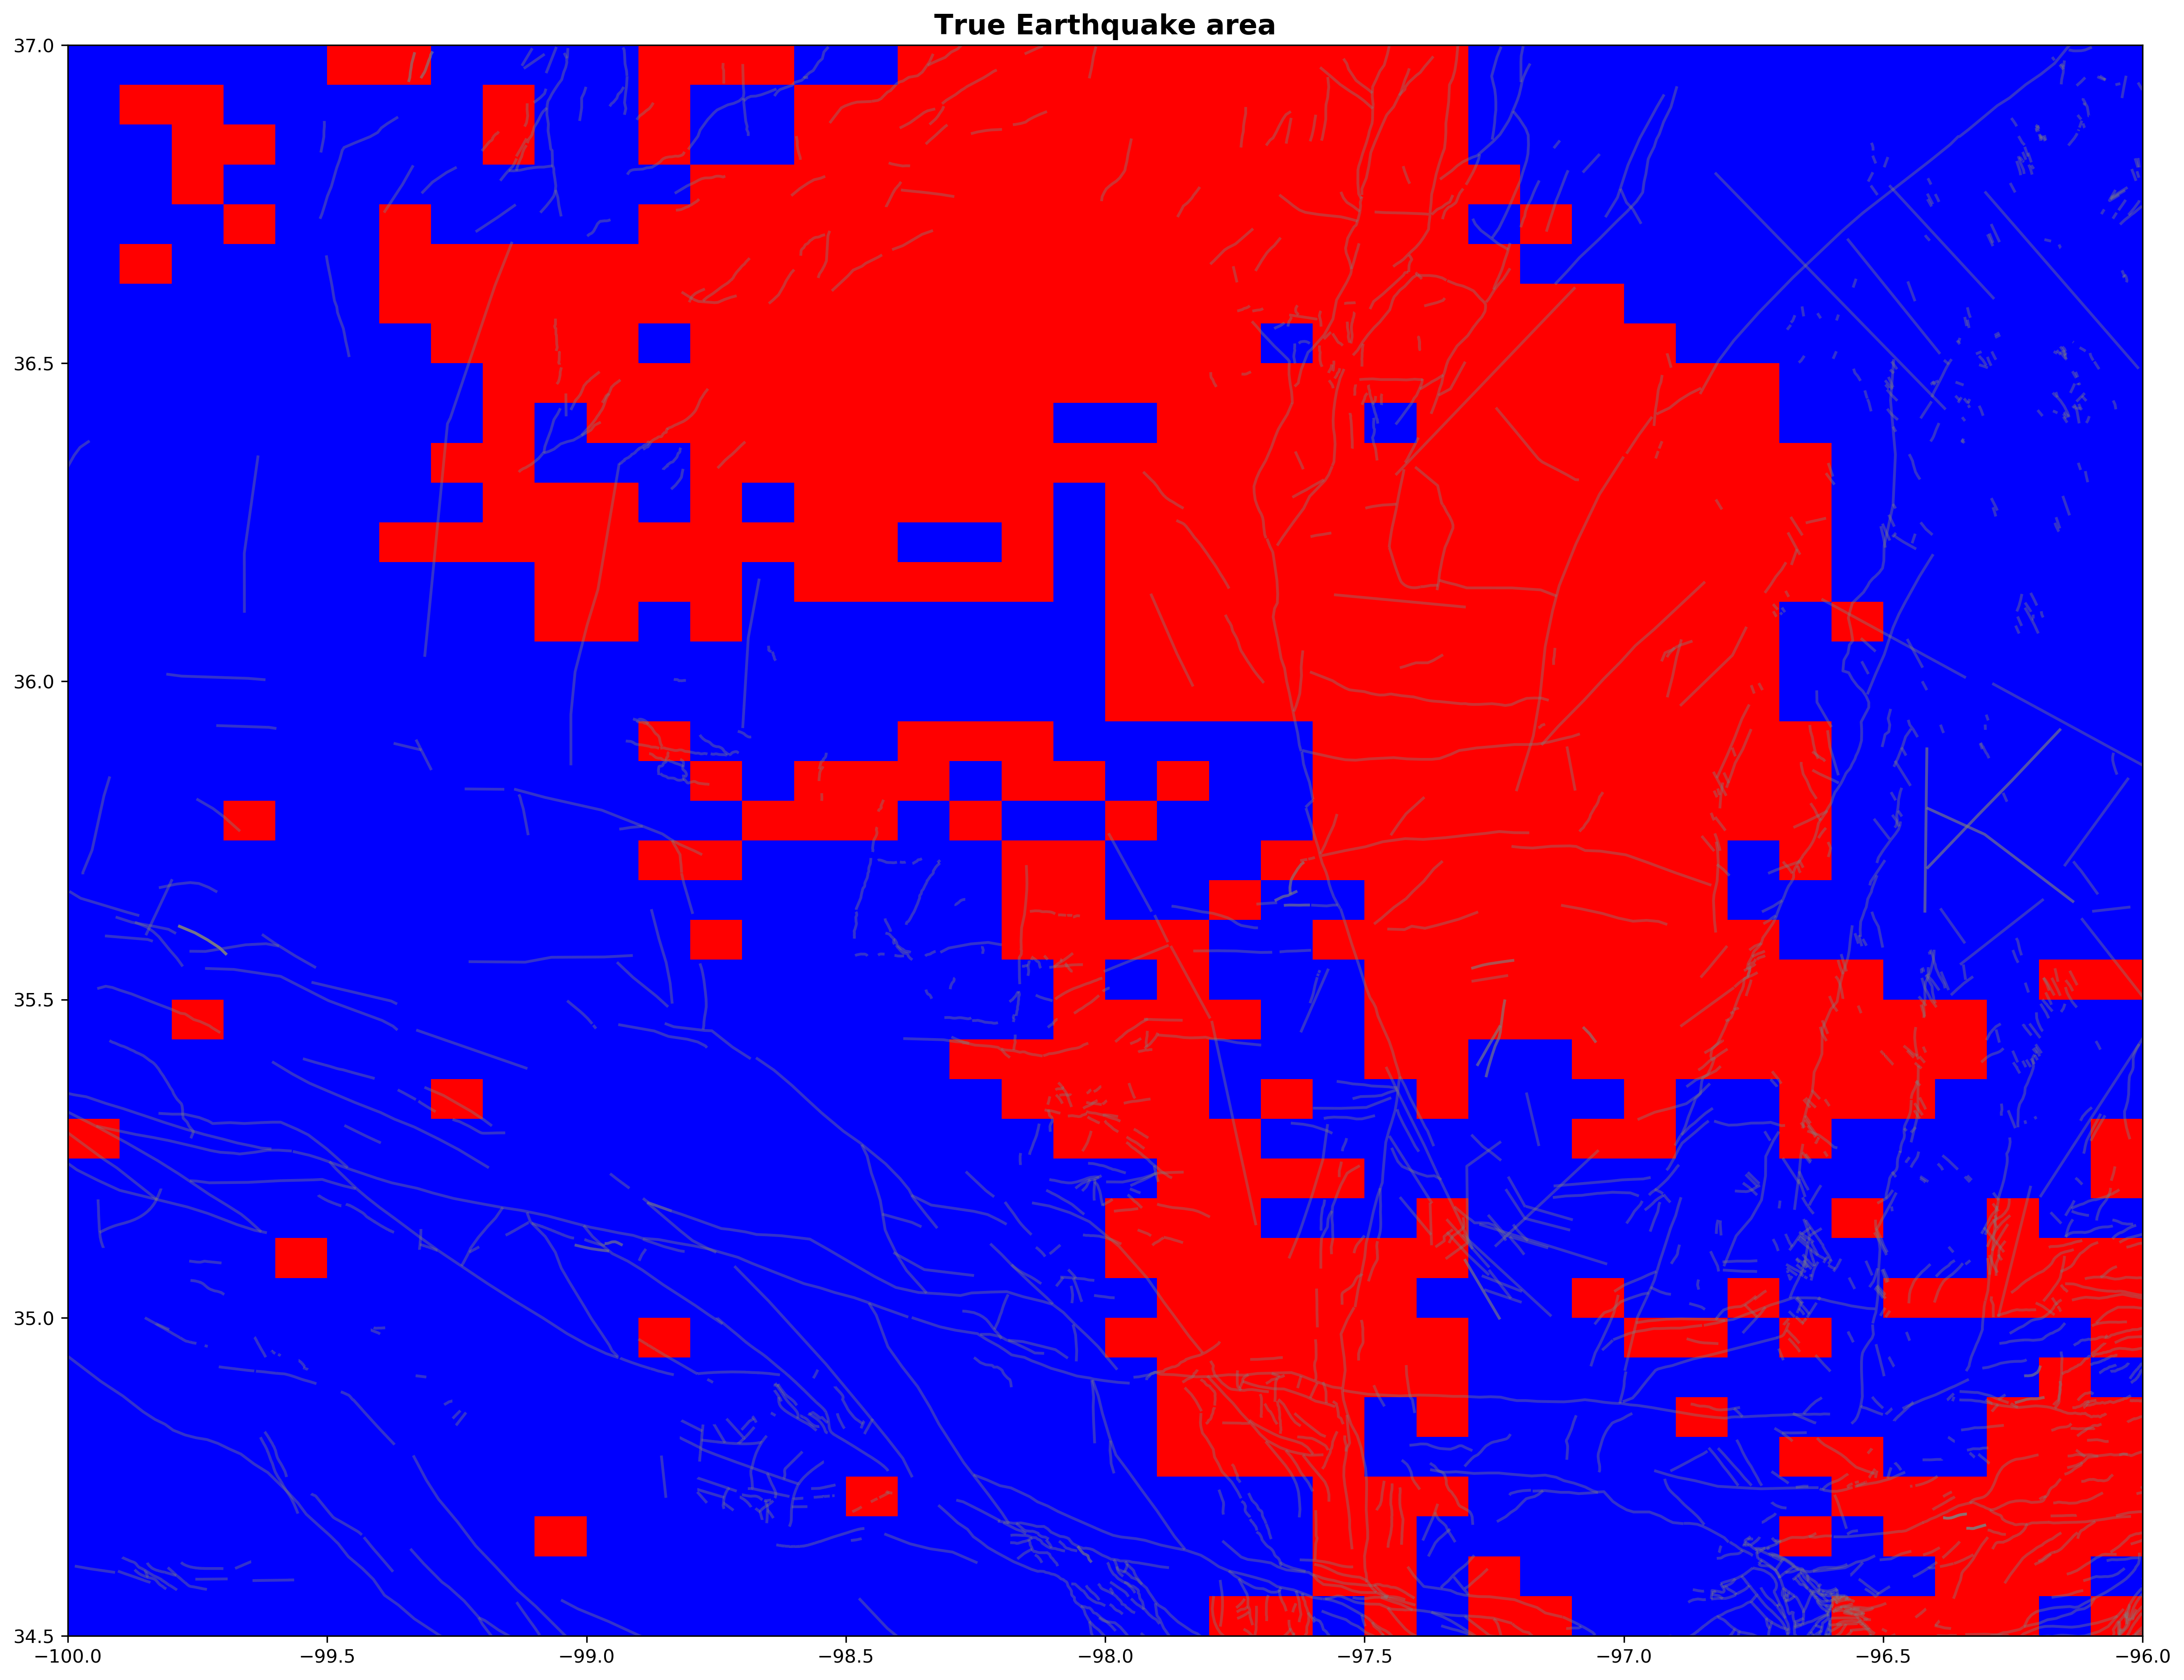

In [1178]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1
# m, n = (41, 41)
x = np.linspace(-100, -96, m)
y = np.linspace(34.5, 37, n)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,1,1)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(34.5, 37, m) # y
lon = np.linspace(-100, -96, n) #x


plot_list = labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1


ax1.set_xlim(-100, -96)
ax1.set_ylim(34.5, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()

# stepwise regression

In [1366]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_columns = df.columns.tolist()[:-1]

#特征features
X = df[x_columns].values
#标签labels
Y = df['class'].values

X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8, random_state=42)

mean_value = np.mean(X_train, axis=0)
std_value = np.std(X_train, axis=0)

feature_number = len(x_columns)
# X_train
for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]

#输出数据大小
print('原始数据特征：',X.shape,
     '训练数据特征：',X_train.shape,
      '测试数据特征',X_test.shape)

print('原始数据标签：',Y.shape,
     '训练数据标签：',y_train.shape,
      '测试数据标签',y_test.shape)

feature_number = len(x_columns)

#将训练数据特征转换成二维数组X行*1列
X_train=X_train.reshape(-1,feature_number)
#将测试数据特征转换成二维数组X行*1列
X_test=X_test.reshape(-1,feature_number)


#第一步：创建模型：逻辑回归
model=LogisticRegression()
#第二步：训练模型
model.fit(X_train,y_train)

#第三步: 评估模型：准确率
model.score(X_test,y_test)

原始数据特征： (1600, 7) 训练数据特征： (1280, 7) 测试数据特征 (320, 7)
原始数据标签： (1600,) 训练数据标签： (1280,) 测试数据标签 (320,)


0.65

In [1367]:
## creating function to get model statistics
def get_stats():
    x = df[x_columns]
    y = df['class']
    
    mean_value = np.mean(x, axis=0)
    std_value = np.std(x, axis=0)

    feature_number = len(x_columns)
    # X_train
    for i in range(0, feature_number):
        feature_name = x_columns[i]
        x[feature_name]= (x[feature_name] - mean_value[feature_name]) / std_value[feature_name]

    results = sm.Logit(y, x).fit()
#     print(results.pvalues)
    print(results.summary())

In [1368]:
get_stats()

Optimization terminated successfully.
         Current function value: 0.631770
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1593
Method:                           MLE   Df Model:                            6
Date:                Wed, 28 Jul 2021   Pseudo R-squ.:                 0.04317
Time:                        17:38:31   Log-Likelihood:                -1010.8
converged:                       True   LL-Null:                       -1056.4
Covariance Type:            nonrobust   LLR p-value:                 1.699e-17
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
injection_vol              0.1912      0.119      1.609      0.108      -0.042      

/Users/zhiyongliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [1335]:
x_columns.remove("HF_Base_Water_Volume")
get_stats()

Optimization terminated successfully.
         Current function value: 0.631783
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1594
Method:                           MLE   Df Model:                            5
Date:                Wed, 28 Jul 2021   Pseudo R-squ.:                 0.04315
Time:                        16:28:12   Log-Likelihood:                -1010.9
converged:                       True   LL-Null:                       -1056.4
Covariance Type:            nonrobust   LLR p-value:                 3.818e-18
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
injection_vol              0.1942      0.118      1.648      0.099      -0.037      

/Users/zhiyongliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [1336]:
x_columns.remove("injection_vol")
get_stats()

Optimization terminated successfully.
         Current function value: 0.632686
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1595
Method:                           MLE   Df Model:                            4
Date:                Wed, 28 Jul 2021   Pseudo R-squ.:                 0.04178
Time:                        16:28:17   Log-Likelihood:                -1012.3
converged:                       True   LL-Null:                       -1056.4
Covariance Type:            nonrobust   LLR p-value:                 3.055e-18
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
injection_psi             -0.6585      0.234     -2.820      0.005      -1.116      

/Users/zhiyongliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [1337]:
x_columns.remove("HF_Base_NoWater_Volume")
get_stats()

Optimization terminated successfully.
         Current function value: 0.634370
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                 1600
Model:                          Logit   Df Residuals:                     1596
Method:                           MLE   Df Model:                            3
Date:                Wed, 28 Jul 2021   Pseudo R-squ.:                 0.03923
Time:                        16:28:26   Log-Likelihood:                -1015.0
converged:                       True   LL-Null:                       -1056.4
Covariance Type:            nonrobust   LLR p-value:                 7.363e-18
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
injection_psi          -0.6575      0.232     -2.829      0.005      -1.113      -0.202
in

/Users/zhiyongliu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [1338]:
#特征features
X = df[x_columns].values
#标签labels
Y = df['class'].values

X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.8, random_state=42)

mean_value = np.mean(X_train, axis=0)
std_value = np.std(X_train, axis=0)

feature_number = len(x_columns)
# X_train
for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]

#输出数据大小
print('原始数据特征：',X.shape,
     '训练数据特征：',X_train.shape,
      '测试数据特征',X_test.shape)

print('原始数据标签：',Y.shape,
     '训练数据标签：',y_train.shape,
      '测试数据标签',y_test.shape)

feature_number = len(x_columns)

#将训练数据特征转换成二维数组X行*1列
X_train=X_train.reshape(-1,feature_number)
#将测试数据特征转换成二维数组X行*1列
X_test=X_test.reshape(-1,feature_number)


#第一步：创建模型：逻辑回归
model=LogisticRegression()
#第二步：训练模型
model.fit(X_train,y_train)

#第三步: 评估模型：准确率
model.score(X_test,y_test)

原始数据特征： (1600, 4) 训练数据特征： (1280, 4) 测试数据特征 (320, 4)
原始数据标签： (1600,) 训练数据标签： (1280,) 测试数据标签 (320,)


0.653125

In [1339]:
model.coef_[0]

array([-1.02452439,  0.61204244, -0.48912495,  0.71091883])

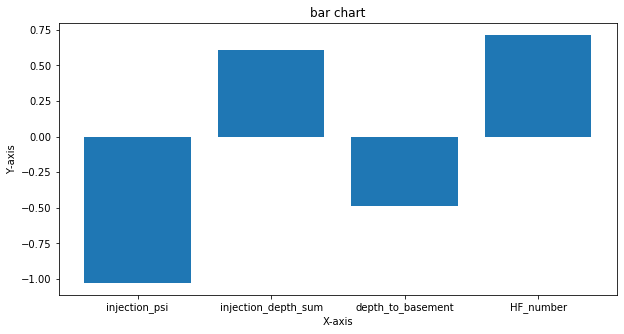

In [1340]:
X = x_columns
Y = model.coef_[0]
fig = plt.figure(figsize=(10, 5))
plt.bar(X,Y)
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("bar chart")

plt.show()

# network construction

In [1341]:
x_columns

['injection_psi', 'injection_depth_sum', 'depth_to_basement', 'HF_number']

In [1342]:
features = df[x_columns]
target = df['class']

In [1343]:
# feature_names = df.columns.tolist()[:-1]

In [1344]:
feature_names = features.columns.tolist()
print(feature_names)

['injection_psi', 'injection_depth_sum', 'depth_to_basement', 'HF_number']


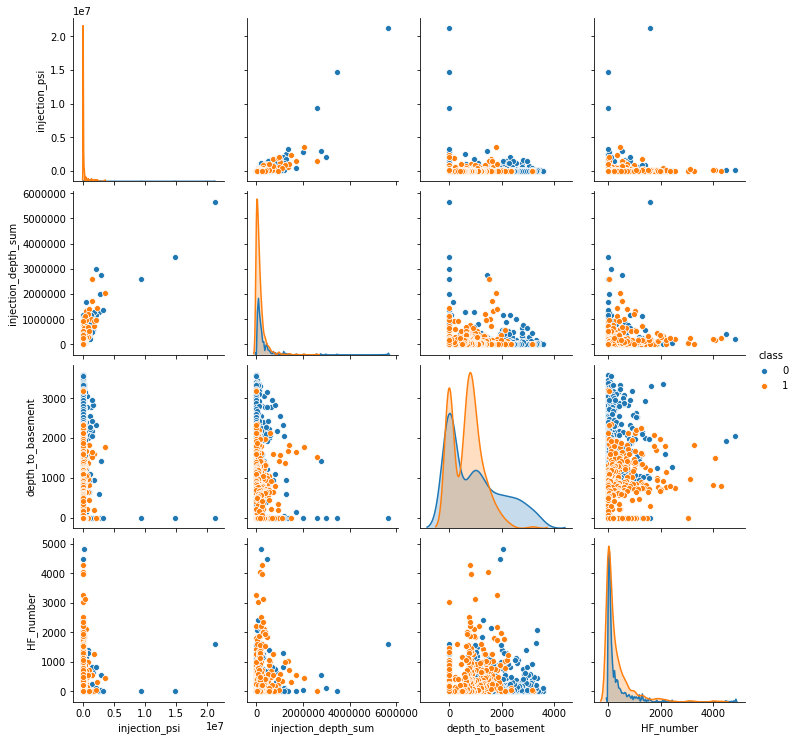

In [1345]:
import matplotlib.pyplot as plt
import seaborn as sns  # seaborn作为matplotlib的补充，导入后会覆盖matplotlib的默认作图风格

sns.pairplot(df, hue='class', vars=feature_names)  # hue : 使用指定变量为分类变量画图；vars : 与data使用，否则使用data的全部变量
plt.show()  # 仍然使用matplotlib的显示函数

In [1347]:
features

injection_psi  injection_depth_sum  depth_to_basement  HF_number
0               0.0                  0.0                0.0          0
1               0.0                  0.0                0.0          0
2               0.0                  0.0                0.0          0
3               0.0                  0.0                0.0          0
4               0.0                  0.0                0.0          0
...             ...                  ...                ...        ...
1595            0.0                  0.0                0.0          0
1596            0.0                  0.0                0.0          0
1597        33600.0              15757.0                0.0          0
1598            0.0                  0.0                0.0          0
1599            0.0               6460.0                0.0          0

[1600 rows x 4 columns]

In [1348]:
class Net(nn.Module):
    def __init__(self,n_input, n_output):
        super(Net,self).__init__()
        self.linear1 = nn.Linear(n_input, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, n_output)
#         self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.linear3(sigmoid_out2)

In [1349]:
def train(model, optimizer, criterion, data_loader):
    """
    The training method, to train the dataset
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, feature_number))
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()  
        
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
  
def validate(model, criterion, data_loader):
    """
    The validation method, to validate and test
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, feature_number))
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            
    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

In [1350]:
# 测试模型是否可用
# x = torch.rand((100,feature_number))
# print(x)
# model = Net(feature_number,20,2)
# result = model(x)
# print (result)
# model = model.to(device)

# Train the model, validation and evaluation

In [1351]:
# Define the hyperparameters
seed = 42
lr = 1e-2
momentum = 0.8
batch_size = 16
test_batch_size = 16
n_epochs = 150

feature_number = len(feature_names)
model = Net(feature_number,2)

In [1352]:
Y = target.values
X = features.values
data_tensor = TensorDataset(torch.tensor(X), torch.tensor(Y))

shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42).split(X, Y)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train = X[indices[0]]
X_test = X[indices[1]]
Y_train = Y[indices[0]]
Y_test = Y[indices[1]]

mean_value = np.mean(X[indices[0]], axis=0)
std_value = np.std(X[indices[0]], axis=0)


for i in range(0, feature_number):
    X_train[:,i] = (X_train[:,i] - mean_value[i]) / std_value[i]
    
for i in range(0, feature_number):
    X_test[:,i] = (X_test[:,i] - mean_value[i]) / std_value[i]


train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [1353]:
print(len(train_dataset))
print(len(val_dataset))

1280
320


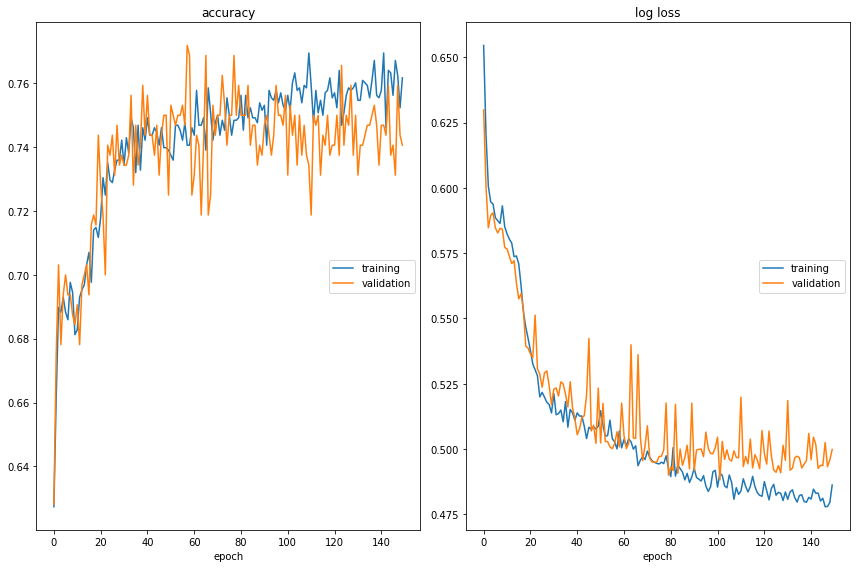

accuracy
	training         	 (min:    0.627, max:    0.770, cur:    0.762)
	validation       	 (min:    0.628, max:    0.772, cur:    0.741)
log loss
	training         	 (min:    0.478, max:    0.655, cur:    0.486)
	validation       	 (min:    0.488, max:    0.630, cur:    0.500)

Avg. Test Loss: 0.500  Avg. Test Accuracy: 0.741


In [1354]:
set_seed(seed)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss, validation_accuracy = validate(model, criterion, test_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()


test_loss, test_accuracy = validate(model, criterion, test_loader)  
print("")
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())

In [1356]:
# 训练集拟合程度
model.eval()
test_features = X_train
test_labels = Y_train
test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor).detach()
out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.75078125


# Feature Importance

In [1357]:
from captum.attr import FeaturePermutation, IntegratedGradients

# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(18,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

Average Feature Importances
injection_psi :  0.143
injection_depth_sum :  -0.125
depth_to_basement :  -0.580
HF_number :  -0.640


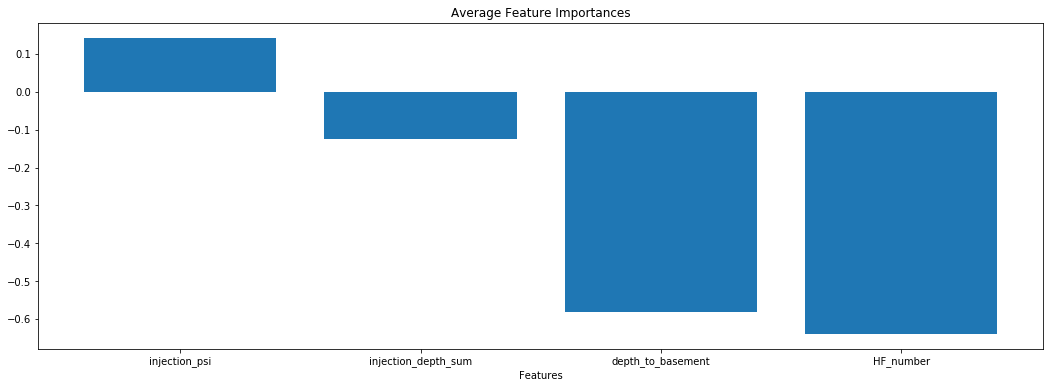

In [1358]:
ig = IntegratedGradients(model)
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()
visualize_importances(feature_names, np.mean(attr, axis=0))

In [1359]:
# 

# Save the model

In [1103]:
model.eval()
model.parameters()
path = "./model/EarthquakePredict_2010-2018_40*40.pt"
torch.save(model.state_dict,path)

# Test on all the dataset to reproduction

In [1360]:
model.eval()
test_features = X
test_labels = Y

for i in range(0, feature_number):
    test_features[:,i] = (test_features[:,i] - mean_value[i]) / std_value[i]

test_input_tensor = torch.from_numpy(test_features)
out_probs = model(test_input_tensor).detach()
out_classes = F.log_softmax(out_probs, dim=1).max(1)[1].numpy()
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.74875


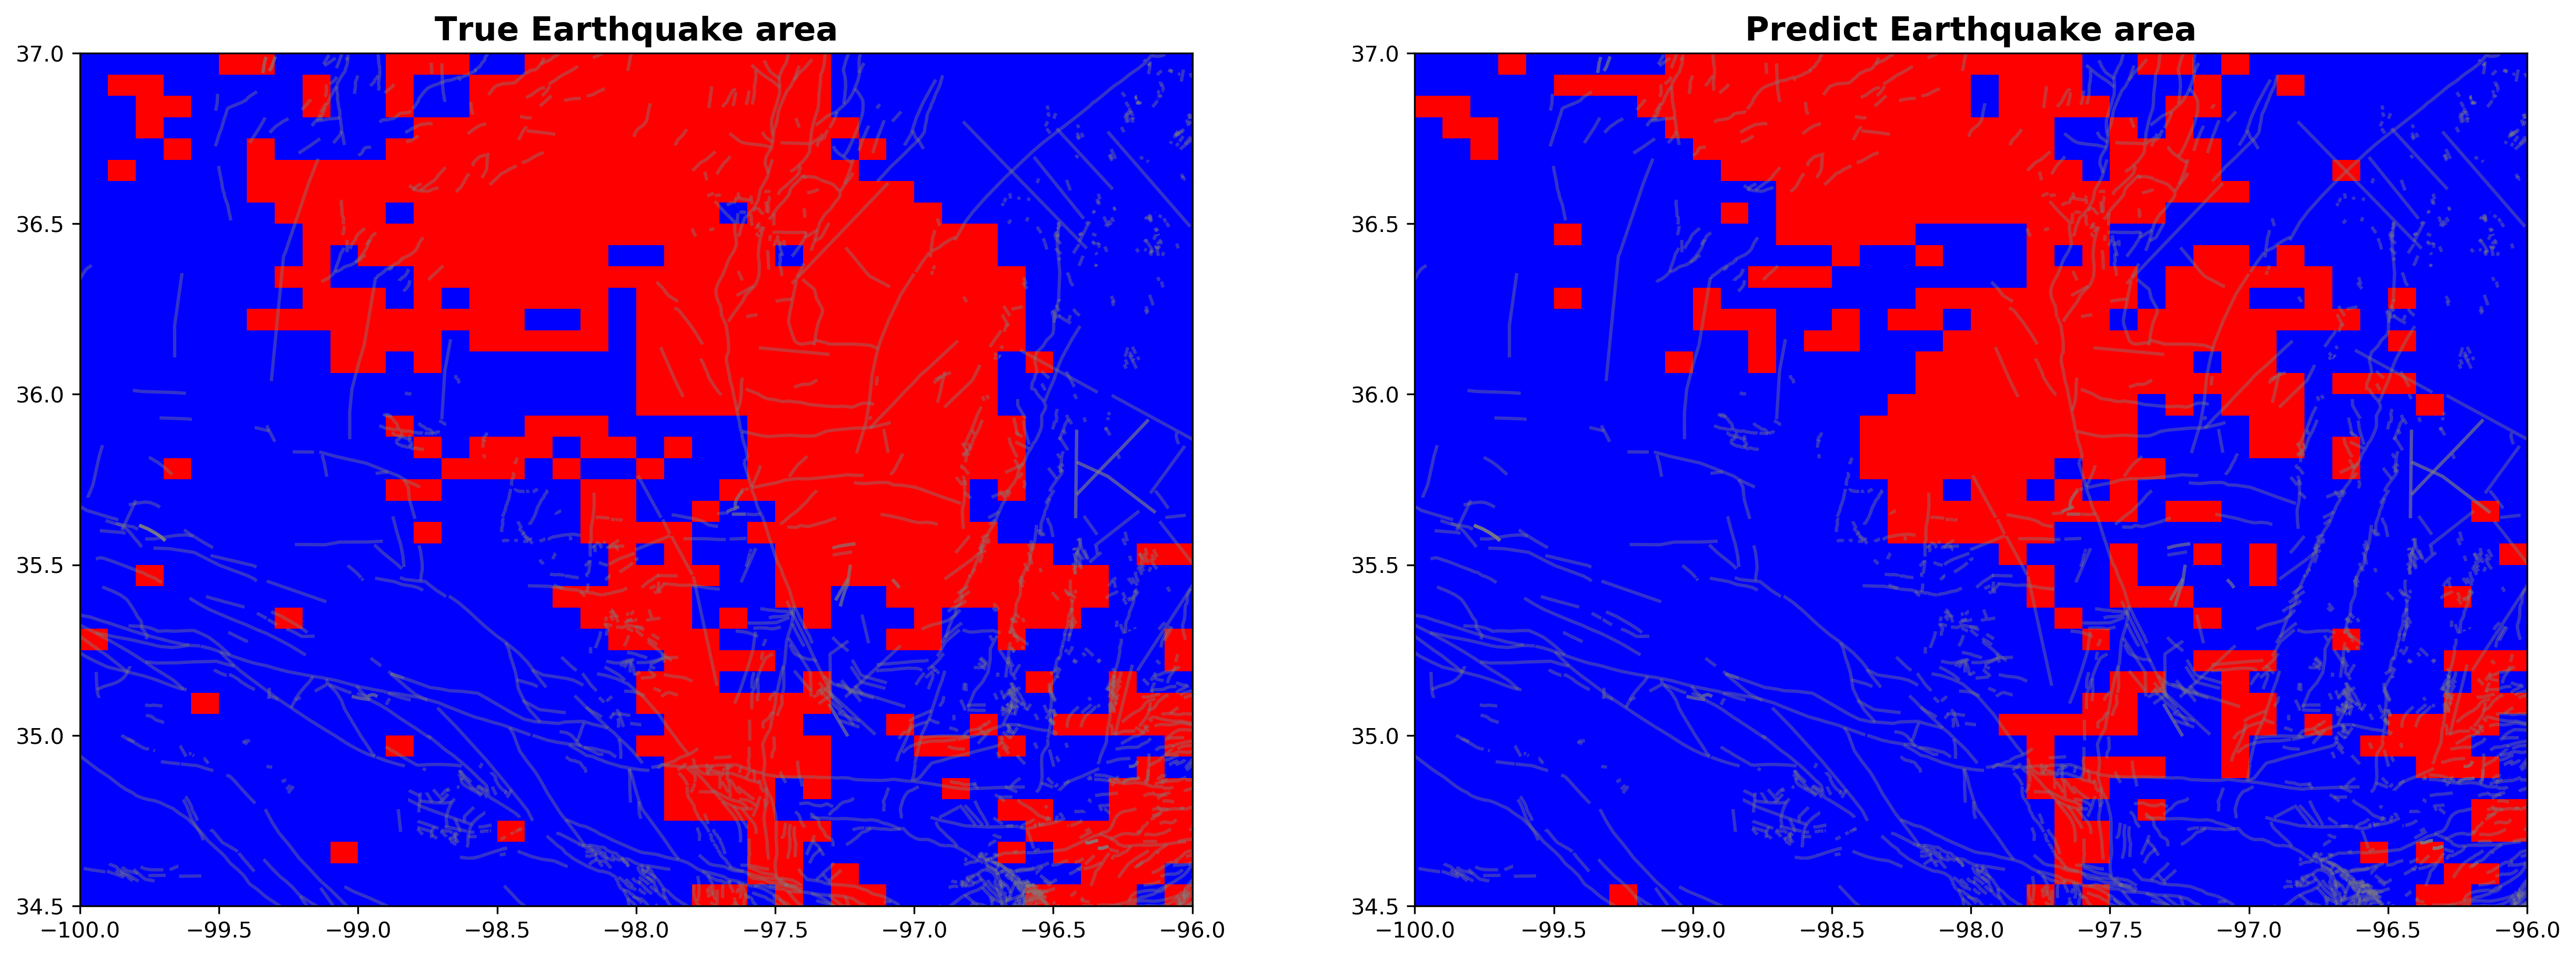

In [1361]:
m = int(pow(len(df), 0.5))+1
n = int(pow(len(df), 0.5))+1

fig = plt.figure(figsize=(20, 20), dpi=300)
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
# add .shp mapfile to axes
# Load the shp file
oklahoma_map = gpd.read_file('datasets/GeologicalData/Interpreted_faults/Interpretative.shp')
oklahoma_map.plot(ax=ax1, alpha=0.4,color='grey')
oklahoma_map.plot(ax=ax2, alpha=0.4,color='grey')

# 设置地图范围
lat = np.linspace(34.5, 37, m) # y
lon = np.linspace(-100, -96, n) #x


plot_list = test_labels
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax1.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

plot_list = out_classes
# 从底到上，一行一行遍历
i = 0
for la_index in range(0, len(lat)-1):
    for lo_index in range(0, len(lon)-1):
#         print(la_index, lo_index)
#         grid = earthquake_df[(earthquake_df['latitude']>lat[la_index])&(earthquake_df['latitude']<lat[la_index+1])&(earthquake_df['longitude']>lon[lo_index])&(earthquake_df['longitude']<lon[lo_index+1])]
        if plot_list[i] == 0:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='blue')
        else:
            ax2.fill_between([lon[lo_index], lon[lo_index+1]],lat[la_index],lat[la_index+1],facecolor='red')
        i = i+1

ax1.set_xlim(-100, -96)
ax1.set_ylim(34.5, 37)
ax2.set_xlim(-100, -96)
ax2.set_ylim(34.5, 37)
ax1.set_title('True Earthquake area', fontsize=15,fontweight='bold')
ax2.set_title('Predict Earthquake area', fontsize=15,fontweight='bold')
# plt.xlim(-98, -97.5)
# plt.ylim(36.5, 37)
# show map
plt.show()